### Ray Paths and TT Curves for the Moon

Written by *Nick Mancinelli*, July 2018

In [209]:
#Read in Alex's Weber model 
%matplotlib inline

model_string  = 'weber_minos_nopml'

import pandas as pd
names = ['Radius_meters','Density','Vp','Vs','Dummy','Dummy','Dummy','Dummy','Dummy']
df = pd.read_csv('%s.txt' % model_string, delim_whitespace = True, skiprows = 3, names = names)

#Adjust units
df['Radius_km'] = df['Radius_meters']/1000.
df['Vp'] = df['Vp']/1000.
df['Vs'] = df['Vs']/1000.
df['Density'] = df['Density']/1000.
radius_max = df.Radius_km.tolist()[-1]
df['Depth_km'] = radius_max - df['Radius_km']
df = df.iloc[::-1]

#Write in .nd format for taup calculation
fout = open('%s.nd' % model_string,'w')

for irow, row in df.iterrows():
    string = '%4.0f %5.1f %5.1f %5.1f\n' % (row.Depth_km, row.Vp, row.Vs, row.Density)
    fout.write(string)
    if irow < len(df.Depth_km.tolist()) and irow > 0:
        if df.loc[irow-1].Depth_km == row.Depth_km:
            if row.Depth_km > 30. and row.Depth_km < 45.:
                fout.write('mantle\n')
            elif row.Depth_km > 1400. and row.Depth_km < 1415.:
                fout.write('outer-core\n')
            elif row.Depth_km > 1490. and row.Depth_km < 1505.:
                fout.write('inner-core\n')
                
fout.close()

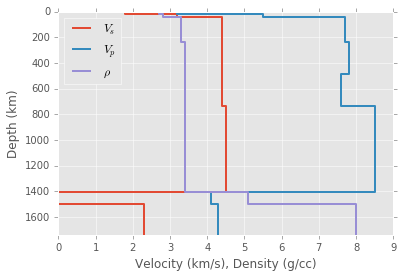

In [210]:
from matplotlib import pylab as plt

plt.figure()

lw = 2

plt.plot(df.Vs, df.Depth_km, label=r'$V_s$', lw = lw)
plt.plot(df.Vp, df.Depth_km, label=r'$V_p$', lw = lw)
plt.plot(df.Density, df.Depth_km, label=r'$\rho$', lw = lw)
_ = plt.ylim(max(df.Depth_km), min(df.Depth_km))
_ = plt.legend(loc='best')
_ = plt.ylabel('Depth (km)')
_ = plt.xlabel('Velocity (km/s), Density (g/cc)')

In [213]:
#Build taup model through obspy wrapper

import obspy
from obspy.taup import taup_create, TauPyModel
taup_create.build_taup_model('weber_minos.nd')
taup_create.build_taup_model('weber_minos_nopml.nd')
model1 = TauPyModel(model="weber_minos")
model2 = TauPyModel(model="weber_minos_nopml")

Building obspy.taup model for 'weber_minos.nd' ...
Building obspy.taup model for 'weber_minos_nopml.nd' ...


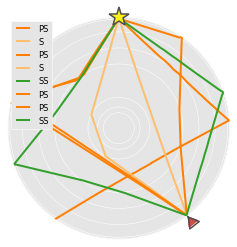

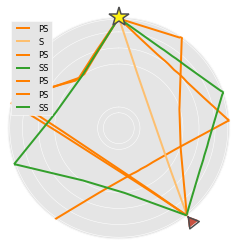

In [263]:
#Plot some ray paths

for model in [model1, model2]:
    arrivals = model.get_ray_paths(source_depth_in_km=0, distance_in_degree=142, phase_list=["S","SS","PS"])
    ax = arrivals.plot_rays(legend=True)

#### Print travel times

for arrival in arrivals:
    print(arrival, arrival.time/60.)

There were 0 epicentral distances without an arrival


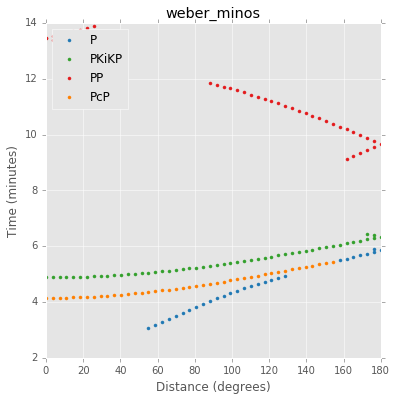

There were 0 epicentral distances without an arrival


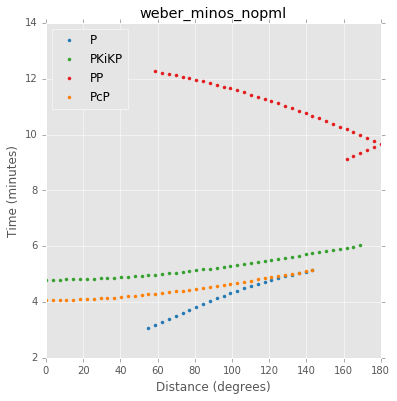

In [274]:
#Plot travel time curves

from obspy.taup import plot_travel_times

import matplotlib.pyplot as plt
plt.style.use('ggplot')



for iplt, model in enumerate(['weber_minos','weber_minos_nopml']):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(model)
    ax = plot_travel_times(model=model, 
                           source_depth=850, 
                           #phase_list=["S","ScS","SS"],
                           phase_list=["P","PcP","PP","PKiKP"],
                           #phase_list=["sS", "S","ScS","SS","SSS","SSSS","P","PKP","PKIKP","PcS","ScP","PcP","pS",'p','s'], 
                           npoints = 50,
                           ax=ax, fig=fig, verbose=True)
    
    

In [260]:
for arrival in arrivals:
    print(arrival.name, arrival.time)

S 752.646329331
SS 952.56765064
SSS 1010.44913504
SSSS 1047.48572745
SS 1311.29723866
SSS 1456.37750784
SSSS 1522.78188764
SSSS 2842.02957622
SSSS 3031.1959846


In [268]:
#Lunar Geometrical Spreading
#
from numpy import arcsin

def get_energy_density(psph, dpsph_ddeldeg, theta1, theta2, deldeg):
    from numpy import cos, sin, pi
    num = psph * abs(dpsph_ddeldeg)
    delrad = deldeg * pi/180.
    den = cos(theta1) * cos(theta2) * sin(delrad)
    return num / den
    

for d0 in range(6,156,10):
    ddeldeg = 0.05
    print('Delta = %d degrees' % d0)
    print('   %5s %7s %7s' % ('Name', 'Time', 'Amp.'))

    source_depth = 0

    arrivals0    = model1.get_ray_paths(source_depth_in_km=source_depth, distance_in_degree=d0, phase_list=["s","sS","S","SS","SSS","SSSS"])
    arrivals_ptb = model1.get_ray_paths(source_depth_in_km=source_depth, distance_in_degree=d0+ddeldeg, phase_list=["s","sS","S","SS","SSS","SSSS"])

    for ii in range(len(arrivals0)):
        psph = arrivals0[ii].ray_param
        dpsph = arrivals_ptb[ii].ray_param - arrivals0[ii].ray_param
        dpsph_ddeldeg = dpsph/ddeldeg
        v1=0.5
        v2=0.5
        r1=1737.-source_depth
        r2=1737.
        theta1 = arcsin(psph*v1/r1)
        theta2 = arcsin(psph*v2/r2)

        energy_density = get_energy_density(psph, dpsph_ddeldeg, theta1, theta2, d0)
        
        string = '   %5s %7.2f %7.2f' % (arrivals0[ii].name, arrivals0[ii].time, energy_density**0.5)
        print(string)
    

Delta = 6 degrees
    Name    Time    Amp.
       S   66.46   20.54
       S   70.14   34.01
       S   72.18  200.50
      SS   83.96   15.79
      SS   92.54    6.81
      SS   93.43  331.53
     SSS   97.77    9.83
       S  101.01   66.32
      SS  101.04   33.18
     SSS  101.05   22.19
    SSSS  101.05   16.56
       S  101.98  200.27
      SS  105.99  373.02
    SSSS  111.58    6.77
     SSS  112.35  496.51
    SSSS  120.70  571.68
     SSS 2060.93   38.42
     SSS 2099.53   38.67
    SSSS 2270.20   39.79
    SSSS 2310.28    4.47
    SSSS 2310.34   15.26
    SSSS 2327.97   39.81
    SSSS 2356.74    7.80
    SSSS 2357.16   13.90
Delta = 16 degrees
    Name    Time    Amp.
       S  133.55   23.96
      SS  159.82   11.02
       S  163.65   35.34
       S  163.78   22.18
      SS  177.79   17.33
      SS  180.38   57.11
     SSS  185.92    6.62
     SSS  191.66   11.29
     SSS  198.84   85.09
    SSSS  205.49    8.26
    SSSS  212.01    4.35
    SSSS  219.22  106.89
      SS  269